OSAR Context Generator PoW test

**Author:** [Konstantin Ustyuzhanin](https://www.facebook.com/konstantin.ustuzhanin/)<br>
**Date created:** 2021/01/27<br>
**Last modified:** 2021/02/10<br>
**Description:** Implement Objective Stimuli Active Repeater (OSAR) Context Generator.

# Installations and imports

In [1]:
import sys
!pip install -q gym
# Install additional packages for visualization
if sys.platform != 'win32':
    !sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay #> /dev/null 2>&1
!pip install -q imageio == 2.4.0
!pip install PILLOW
!pip install pyglet
!pip install -q git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install git+https://github.com/ustyuzhaninky/OSAR-keras
# !pip install ../../OSAR-keras/.

Processing d:\jorgen\projects\python\phdsub\towerproject\osar-keras
  Created wheel for OSAR: filename=OSAR-0.1.5-py3-none-any.whl size=60214 sha256=70dd206f3d6e22e7479a493772f718008e9828b2dc3739f8f909bcbba3a7cec4
  Stored in directory: c:\users\jorgen\appdata\local\pip\cache\wheels\df\60\40\81c908253910a541e172b609cc54a7a5400e85a6fba88b292e
Successfully built OSAR
  Attempting uninstall: OSAR
    Found existing installation: OSAR 0.1.5
    Uninstalling OSAR-0.1.5:
      Successfully uninstalled OSAR-0.1.5


In [2]:
import os
import collections
import gym
import numpy as np
import tensorflow as tf
import tqdm
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple
import numpy as np
from tf_agents import agents
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tensorflow.keras import layers
os.environ['TF_KERAS'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
# Configuration parameters for the whole setup
seed = 42

TensorFlow version: 2.4.1
Eager execution: True


In [3]:
from OSAR import OSARNetwork, DQNRewardedAgent

In [4]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [5]:
tf.version.VERSION

'2.4.1'

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 10 # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 10000  # @param {type:"integer"}

batch_size = 1  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 1  # @param {type:"integer"}
memory_len = 3 # @param {type: "integer"}
n_turns = 3 # @param {type: "integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

Load the CartPole environment from the OpenAI Gym suite. 

In [8]:
env_name = 'Alien-ram-v0'
env = suite_gym.load(env_name)

In [9]:
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

You can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up.

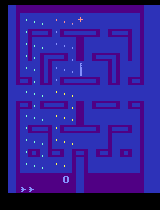

In [10]:
env.reset()
PIL.Image.fromarray(env.render())

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [11]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(128,), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)


In [12]:
print('Observation Spec:')
print(env.time_step_spec())

Observation Spec:
TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(128,), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))


In [13]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [14]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=17)


Usually two environments are instantiated: one for training and one for evaluation. 

In [15]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [16]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Functions

In [17]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
    """Computes the combined actor-critic loss."""

    advantage = returns - values

    action_log_probs = tf.math.log(action_probs)
    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

    critic_loss = huber_loss(values, returns)

    return actor_loss + critic_loss

In [18]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
    """Compute expected returns per timestep."""

    n = tf.shape(rewards)[0]
    returns = tf.TensorArray(dtype=tf.float32, size=n)

    # Start from the end of `rewards` and accumulate reward sums
    # into the `returns` array
    rewards = tf.cast(rewards[::-1], dtype=tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
#         discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    returns = returns.stack()[::-1]

    if standardize:
        returns = ((returns - tf.math.reduce_mean(returns)) / 
                   (tf.math.reduce_std(returns) + eps))

    return returns

In [19]:
# @tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int,
    ) -> Tuple[tf.Tensor, List[tf.Tensor]]:
    """Runs a model training step."""

    with tf.GradientTape() as tape:

        # Run the model for one episode to collect training data
        action_probs, values, rewards, x_values = run_episode(
            initial_state, model, max_steps_per_episode) 

        # Calculate expected returns
        returns = get_expected_return(rewards, gamma)

        # Convert training data to appropriate TF tensor shapes
        action_probs, values, returns = [
#             tf.expand_dims(x, 1) for x in [action_probs, values, returns]]
            tf.cast(x, tf.float32) for x in [action_probs, values, returns]] 

        # Calculating loss values to update our network
        loss = compute_loss(action_probs, values, returns)

        # Compute the gradients from the loss
        grads = tape.gradient(loss, model.trainable_variables)

        # Apply the gradients to the model's parameters
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    episode_reward = tf.math.reduce_sum(rewards)
    episode_x = tf.math.reduce_mean(x_values)
    episode_loss = tf.math.reduce_mean(loss)
    episode_actions = tf.math.reduce_mean(action_probs)
    episode_values = tf.math.reduce_sum(values)

    return episode_reward, [episode_reward, episode_x, episode_loss, episode_actions, episode_values]

In [20]:
def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns state, reward and done flag given an action."""
    
    time_step = env.step(action)
    state, reward, done = time_step.observation, time_step.reward, 0
    reward = tf.cast(reward, tf.float32)
    return (state.astype(np.uint8), 
            np.array(reward, np.float32), 
            np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
    return tf.numpy_function(env_step, [action], 
                             [tf.uint8, tf.float32, tf.int32])

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [22]:
def run_episode(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    max_steps: int,
    initial_reward: tf.Tensor = tf.zeros((1,1), dtype=tf.float32), 
) -> List[tf.Tensor]:
    """Runs a single episode to collect training data."""

    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    x_values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

    initial_state_shape = initial_state.shape
    state = initial_state
    reward = initial_reward
        
    for t in tf.range(max_steps):
#         tf.autograph.experimental.set_loop_options(
#             shape_invariants=[(reward, tf.TensorShape([1,]))]
#             )
        
        if tf.rank(state) < 2:
            state = tf.expand_dims(state, axis=0)
            reward = tf.expand_dims(tf.expand_dims(reward, axis=-1), axis=-1)
        
        # Run the model and to get action probabilities and critic value
        action_logits_t, value = model(state, reward)
        
        # Sample next action from the action probability distribution
        action = tf.random.categorical(action_logits_t, env.action_space.n-1)[0, 0]
#         action = tf.argmax(action_logits_t, axis=-1)
        action_probs_t = tf.nn.softmax(action_logits_t)
        last_action = action_probs_t
        
        # store last_action values
        x_values = x_values.write(t, last_action)
        
        # Store critic values
        values = values.write(t, tf.squeeze(value))

        # Store log probability of the action chosen
        action_probs = action_probs.write(t, tf.reduce_max(action_probs_t, axis=-1))
        # Apply action to the environment to get next state and reward
        state, episode_reward, done = tf_env_step(action)
#         state.set_shape(initial_state_shape)

        # Store reward
        rewards = rewards.write(t, episode_reward)
        reward = episode_reward
        
        if tf.cast(done, tf.bool):
            break

    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()
    x_values = x_values.stack()

    return action_probs, values, rewards, x_values

In [23]:
# @tf.function
def run(model:tf.keras.Model,
        env,
        inits:int,
        max_episodes:int,
        max_steps_per_episode:int,
        reward_threshold:float,
        gamma:int,
        ) -> List[tf.Tensor]:
    
    running_reward = 0
    train_history = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    
    with tqdm.trange(max_episodes) as t:
        for i in t:
            initial_state = env.reset().observation
            episode_reward, hist = model.train_step(
                initial_state, optimizer, gamma,
                max_steps_per_episode)
            episode_reward = tf.cast(episode_reward, tf.float32)
            hist = tf.concat([
                tf.cast(tf.expand_dims(x, 0), tf.float32) for x in hist], axis=0)
            train_history = train_history.write(i, hist)
            
            running_reward = episode_reward*0.01 + running_reward*.99

            t.set_description(f'Episode {i}')
            if hasattr(episode_reward, 'numpy'):
                episode_reward = episode_reward.numpy()
                running_reward = running_reward.numpy()
            else:
                episode_reward = episode_reward
                running_reward = running_reward
            t.set_postfix(
                episode_reward=episode_reward, running_reward=running_reward)

            # Show average episode reward every 10 episodes
#             if i % 10 == 0:
#                 print(f'Episode {i}: average reward: {running_reward:.2f}')
            if tf.get_static_value(running_reward) > reward_threshold:  
                break
    
    train_history = train_history.stack()
    print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')
    return train_history

## Agents

In [24]:
fc_layer_params = (10,)

q_net = OSARNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    batch_size,
    memory_len,
    n_turns,
    fc_layer_params=fc_layer_params,
    conv_type='1d',
    )

action_spec = tf.nest.flatten(env.action_spec())[0]
num_actions = action_spec.maximum - action_spec.minimum + 1

class ModelWrapper(tf.keras.models.Model):
    def __init__(self, network, fc_layer_params):
        super().__init__()
        self.network = network
        self.network_state = ()
        self.fc_layer_params = fc_layer_params
#     @tf.function
    def train_step(self, initial_state: tf.Tensor, 
            optimizer: tf.keras.optimizers.Optimizer, 
            gamma: float, 
            max_steps_per_episode: int, dtype=tf.float32) -> Tuple[tf.Tensor, List[tf.Tensor]]:
        return train_step(
               initial_state, self, optimizer, gamma,
               max_steps_per_episode)
    @tf.function
    def call(self, inputs: tf.Tensor, reward:tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        value, critic, self.network_state = self.network(inputs, reward=reward, )#network_state=self.network_state)
        return value, critic
    
osar = ModelWrapper(q_net, fc_layer_params)
osar.compile(loss=tf.keras.losses.Huber,
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
             run_eagerly=False)

## Training

In [25]:
max_episodes = 1000
max_steps_per_episode = 1000
num_hidden = 10
# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 300#195.0

# Discount factor for future rewards
gamma = 0.99

In [26]:
%%time
# osar = get_OSAR(num_hidden=num_hidden,)
osar
with tf.device('/device:GPU:0'):
    osar_hist = run(osar,
                    train_env,
                    num_hidden,
                    max_episodes,
                    max_steps_per_episode,
                    reward_threshold,
                    gamma,)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Jorgen\AppData\Local\Temp\tmpl3bp49vd.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  retval_ = ag__.and_((lambda : (ag__.ld(state) is not None)), (lambda : ag__.and_((lambda : (ag__.ld(state) is not ())), (lambda : (ag__.ld(state) is not [])))))


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not call `graph_parents`.


Episode 136:  14%|██▉                  | 137/1000 [2:33:50<16:09:07, 67.38s/it, episode_reward=280, running_reward=133]


KeyboardInterrupt: 

## Results

In [27]:
labels = ['episode_reward', 'episode_x', 'episode_loss', 'episode_actions', 'episode_values']

In [28]:
def get_running_reward(rewards):
    running_reward = [0]
    for r in rewards:
        running_reward.append(r*0.01 + running_reward[-1]*.99)
    return running_reward

NameError: name 'baseline_hist' is not defined

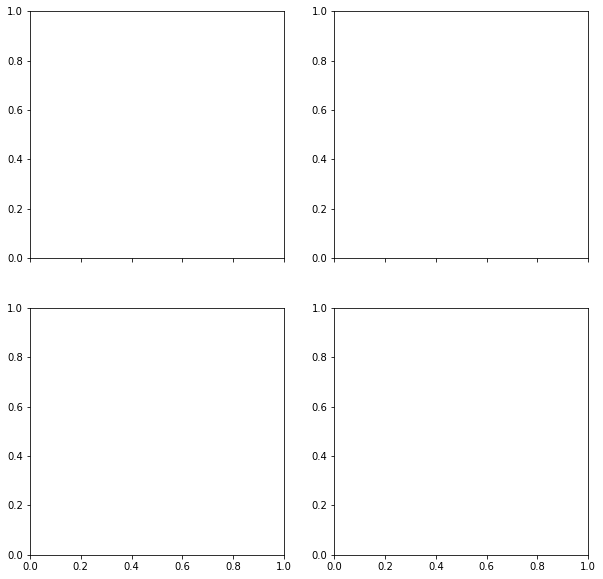

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Anaconda3\envs\osar\lib\site-packages\IPython\core\magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)  File "C:\Anaconda3\envs\osar\lib\site-packages\IPython\core\magics\execution.py", line 1329, in time
    return  File "<timed exec>", line 4, in <module>  File "<ipython-input-23-b25345845e68>", line 41, in run
    break  File "C:\Users\Jorgen\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 10))

ax[0, 0].plot(get_running_reward(baseline_hist[:, 0]), '--', alpha=0.7, label='baseline')
ax[0, 0].plot(get_running_reward(osar_hist[:, 0]), label='osar')
ax[0, 0].plot(get_running_reward(gru_hist[:, 0]), alpha=0.4, label='GRU')
ax[0, 0].set_title('Накопленная награда')
ax[0, 0].legend()
ax[1, 0].plot(baseline_hist[:, 2], '--', alpha=0.7, label='baseline')
ax[1, 0].plot(osar_hist[:, 2], label='osar')
ax[1, 0].plot(gru_hist[:, 2], alpha=0.4, label='gru')
ax[1, 0].set_title('Функция потерь')
ax[1, 0].legend()
ax[0, 1].plot(get_running_reward(baseline_hist[:, 4]), '--', alpha=0.7, label='Критик baseline')
ax[0, 1].plot(get_running_reward(osar_hist[:, 4]), label='Критик osar')
ax[0, 1].plot(get_running_reward(baseline_hist[:, 0]),'--', alpha=0.7, label='Награда baseline')
ax[0, 1].plot(get_running_reward(osar_hist[:, 0]), label='Награда osar')
ax[0, 1].plot(get_running_reward(gru_hist[:, 0]), alpha=0.4, label='Награда GRU')
ax[0, 1].plot(get_running_reward(gru_hist[:, 4]), alpha=0.4, label='Критик GRU')
ax[0, 1].set_title('Реальная награда и ожидаемая награды Критика')
ax[0, 1].legend()
ax[1, 1].plot(baseline_hist[:, 3], '--', alpha=0.7, label='baseline')
ax[1, 1].plot(osar_hist[:, 3], label='osar')
ax[1, 1].plot(gru_hist[:, 3], alpha=0.4, label='GRU')
ax[1, 1].set_title('Функция уверенности в выбранном действии')
ax[1, 1].legend()
plt.show()

In [ ]:
plt.bar(range(len(gru_hist)), baseline_hist[:len(gru_hist), 0], alpha=0.7, label='baseline')
plt.bar(range(len(gru_hist)), gru_hist[:, 0], alpha=0.4,
        bottom=baseline_hist[:len(gru_hist), 0], label='GRU')
plt.bar(range(len(gru_hist)), osar_hist[:len(gru_hist), 0], alpha=0.7, label='osar',
       bottom=baseline_hist[:len(gru_hist), 0]+osar_hist[:len(gru_hist), 0])
plt.title('Награда за эпизод игры')
plt.legend()
plt.show()

# Visualisation

In [ ]:
# Render an episode and save as a GIF file

import sys
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display
# import tensorflow_docs.vis.embed as embed

if sys.platform != 'win32':
    display = Display(visible=0, size=(400, 300))
    display.start()


def render_episode(env, model: tf.keras.Model, max_steps: int, m_type:int=1, inits:int=num_hidden,): 
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)

    images = [im]
    
    reward, loop_var = tf.zeros((1, 1), tf.float32), tf.zeros((1, inits), tf.float32)

    state = tf.constant(env.reset(), dtype=tf.float32)
    for i in range(1, max_steps + 1):
        
        if m_type == 1: 
            action_probs, _, loop_var = model(state)
            action = tf.random.categorical(action_probs, env.action_space.n)[0, 0]
        else:
            action_probs, _, loop_var = model([state, reward, tf.nn.softmax(loop_var)])
            action = tf.random.categorical(action_probs, env.action_space.n)[0, 0]
        
        state, reward, done, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)
        reward = tf.constant(reward, dtype=tf.float32)

        # Render screen every 10 steps
        if i % 10 == 0:
            screen = env.render(mode='rgb_array')
            images.append(Image.fromarray(screen))

        if done:
            break
    env.close()
    return images

## Untrained:

### Baseline

In [ ]:
# Save GIF image
buggy_baseline = get_baseline()
run(buggy_baseline, 10, 100, max_steps_per_episode, reward_threshold, gamma, m_type=1)
images = render_episode(env, buggy_baseline, max_steps_per_episode)
image_untrained_baseline_file = '../images/alien-baseline-untrained-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_untrained_baseline_file, save_all=True, append_images=images[1:], loop=0, duration=1)
# embed.embed_file(image_untrained_baseline_file)

### GRU

In [ ]:
# Save GIF image
buggy_gru = get_GRU(num_hidden=10,)
run(buggy_gru, 10, 100, max_steps_per_episode, reward_threshold, gamma, m_type=1)
images = render_episode(env, buggy_gru, max_steps_per_episode, m_type=1)
image_untrained_gru_file = '../images/alien-gru-untrained-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_untrained_gru_file, save_all=True, append_images=images[1:], loop=0, duration=1)
# embed.embed_file(image_untrained_osar_file)

### OSAR (Context Genrator + GRU Only)

In [ ]:
# Save GIF image
buggy_osar = get_OSAR(num_hidden=10,)
run(buggy_osar, 10, 100, max_steps_per_episode, reward_threshold, gamma, m_type=2)
images = render_episode(env, buggy_osar, max_steps_per_episode, m_type=2)
image_untrained_osar_file = '../images/alien-osar-untrained-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_untrained_osar_file, save_all=True, append_images=images[1:], loop=0, duration=1)
# embed.embed_file(image_untrained_osar_file)

## Trained:

### Baseline

In [ ]:
# Save GIF image
images = render_episode(env, baseline, max_steps_per_episode)
image_trained_baseline_file = '../images/alien-baseline-trained-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_trained_baseline_file, save_all=True, append_images=images[1:], loop=0, duration=1)
# embed.embed_file(image_trained_baseline_file)

### GRU

In [ ]:
# Save GIF image
images = render_episode(env, gru, max_steps_per_episode)
image_trained_gru_file = '../images/alien-gru-trained-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_trained_gru_file, save_all=True, append_images=images[1:], loop=0, duration=1)
# embed.embed_file(image_trained_baseline_file)

### OSAR (Context Genrator + GRU Only)

In [ ]:
# Save GIF image
images = render_episode(env, osar, max_steps_per_episode, m_type=2)
image_trained_osar_file = '../images/alien-osar-trained-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_trained_osar_file, save_all=True, append_images=images[1:], loop=0, duration=1)
# embed.embed_file(image_trained_osar_file)